# 0. Setup Paths

In [1]:
import os
import numpy as np
import re

In [2]:
CUSTOM_MODEL_NAME = 'ssdlite_mobiledet_edgetpu_tuned12' 
PRETRAINED_MODEL_NAME = 'ssdlite_mobiledet_edgetpu_320x320_coco_2020_05_19'
PRETRAINED_MODEL_URL = 'http://download.tensorflow.org/models/object_detection/ssdlite_mobiledet_edgetpu_320x320_coco_2020_05_19.tar.gz'
TF_RECORD_SCRIPT_NAME = 'generate_tfrecord.py'
LABEL_MAP_NAME = 'label_map.pbtxt'

In [3]:
paths = {
    'WORKSPACE_PATH': os.path.join('Tensorflow', 'workspace'),
    'SCRIPTS_PATH': os.path.join('Tensorflow','scripts'),
    'APIMODEL_PATH': os.path.join('Tensorflow','models'),
    'ANNOTATION_PATH': os.path.join('Tensorflow', 'workspace','annotations'),
    'IMAGE_PATH': os.path.join('Tensorflow', 'workspace','images'),
    'MODEL_PATH': os.path.join('Tensorflow', 'workspace','models'),
    'PRETRAINED_MODEL_PATH': os.path.join('Tensorflow', 'workspace','pre-trained-models'),
    'CHECKPOINT_PATH': os.path.join('Tensorflow', 'workspace','models',CUSTOM_MODEL_NAME), 
    'OUTPUT_PATH': os.path.join('Tensorflow', 'workspace','models',CUSTOM_MODEL_NAME, 'export'),
    'TFLITE_PATH':os.path.join('Tensorflow', 'workspace','models',CUSTOM_MODEL_NAME, 'tfliteexport'), 
    'PROTOC_PATH':os.path.join('Tensorflow','protoc')
 }

In [4]:
files = {
    'PIPELINE_CONFIG':os.path.join('Tensorflow', 'workspace','models', CUSTOM_MODEL_NAME, 'pipeline.config'),
    'TF_RECORD_SCRIPT': os.path.join(paths['SCRIPTS_PATH'], TF_RECORD_SCRIPT_NAME), 
    'LABELMAP': os.path.join(paths['ANNOTATION_PATH'], LABEL_MAP_NAME)
}

In [5]:
for path in paths.values():
    if not os.path.exists(path):
        if os.name == 'posix':
            !mkdir -p {path}
        if os.name == 'nt':
            !mkdir {path}

# 1. Download TF Models Pretrained Models from Tensorflow Model Zoo and Install TFOD

In [ ]:
# https://www.tensorflow.org/install/source_windows

In [ ]:
if os.name=='nt':
    !pip install wget
import wget
  

In [ ]:
if not os.path.exists(os.path.join(paths['APIMODEL_PATH'], 'research', 'object_detection')):
    !git clone https://github.com/tensorflow/models {paths['APIMODEL_PATH']}

In [ ]:
# Install Tensorflow Object Detection 
if os.name=='posix':  
    !apt-get install protobuf-compiler
    !cd Tensorflow/models/research && protoc object_detection/protos/*.proto --python_out=. && cp object_detection/packages/tf2/setup.py . && python -m pip install . 
    
if os.name=='nt':
    url="https://github.com/protocolbuffers/protobuf/releases/download/v3.15.6/protoc-3.15.6-win64.zip"
    wget.download(url)
    !move protoc-3.15.6-win64.zip {paths['PROTOC_PATH']}
    !cd {paths['PROTOC_PATH']} && tar -xf protoc-3.15.6-win64.zip
    os.environ['PATH'] += os.pathsep + os.path.abspath(os.path.join(paths['PROTOC_PATH'], 'bin'))   
    !cd Tensorflow/models/research && protoc object_detection/protos/*.proto --python_out=. && copy object_detection\\packages\\tf1\\setup.py setup.py && python setup.py build && python setup.py install
    !cd Tensorflow/models/research/slim && pip install -e . 

In [ ]:
!pip install numpy

In [ ]:
pip show tensorflow-gpu


In [ ]:
!pip install tensorflow==1.15


In [ ]:
pip install tensorflow-text==1.15.1

In [6]:
VERIFICATION_SCRIPT = os.path.join(paths['APIMODEL_PATH'], 'research', 'object_detection', 'builders', 'model_builder_tf1_test.py')
# Verify Installation
!python {VERIFICATION_SCRIPT}

2022-03-24 20:10:41.245146: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library cudart64_100.dll
Running tests under Python 3.7.10: D:\antrenare_cuant\TFODCourse\cuant\Scripts\python.exe
[ RUN      ] ModelBuilderTF1Test.test_create_context_rcnn_from_config_with_params0 (True)
D:\antrenare_cuant\TFODCourse\cuant\lib\site-packages\tensorflow_core\python\training\tracking\data_structures.py:669: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  if not isinstance(wrapped_dict, collections.Mapping):
[       OK ] ModelBuilderTF1Test.test_create_context_rcnn_from_config_with_params0 (True)
[ RUN      ] ModelBuilderTF1Test.test_create_context_rcnn_from_config_with_params1 (False)
[       OK ] ModelBuilderTF1Test.test_create_context_rcnn_from_config_with_params1 (False)
[ RUN      ] ModelBuilderTF1Test.test_create_experimental_model


In [ ]:
!pip show tensorflow-gpu

In [ ]:
!pip uninstall kiwisolver


In [ ]:
!pip uninstall protobuf matplotlib -y
!pip install protobuf matplotlib==3.2

In [ ]:
!pip install pillow

In [ ]:
import object_detection

In [ ]:
!pip list

In [ ]:
if os.name =='posix':
    !wget {PRETRAINED_MODEL_URL}
    !mv {PRETRAINED_MODEL_NAME+'.tar.gz'} {paths['PRETRAINED_MODEL_PATH']}
    !cd {paths['PRETRAINED_MODEL_PATH']} && tar -zxvf {PRETRAINED_MODEL_NAME+'.tar.gz'}
if os.name == 'nt':
    wget.download(PRETRAINED_MODEL_URL)
    !move {PRETRAINED_MODEL_NAME+'.tar.gz'} {paths['PRETRAINED_MODEL_PATH']}
    !cd {paths['PRETRAINED_MODEL_PATH']} && tar -zxvf {PRETRAINED_MODEL_NAME+'.tar.gz'}

# 2. Create Label Map

In [6]:
labels = [{'name':'stop', 'id':1}, {'name':'straight ahead', 'id':2}, {'name':'limit60km', 'id':3}, {'name':'turn right', 'id':4}]

with open(files['LABELMAP'], 'w') as f:
    for label in labels:
        f.write('item { \n')
        f.write('\tname:\'{}\'\n'.format(label['name']))
        f.write('\tid:{}\n'.format(label['id']))
        f.write('}\n')

# 3. Create TF records

In [71]:
# OPTIONAL IF RUNNING ON COLAB
ARCHIVE_FILES = os.path.join(paths['IMAGE_PATH'], 'archive.tar.gz')
if os.path.exists(ARCHIVE_FILES):
  !tar -zxvf {ARCHIVE_FILES}

In [108]:
if not os.path.exists(files['TF_RECORD_SCRIPT']):
    !git clone https://github.com/nicknochnack/GenerateTFRecord {paths['SCRIPTS_PATH']}

In [82]:
!python {files['TF_RECORD_SCRIPT']} -x {os.path.join(paths['IMAGE_PATH'], 'train')} -l {files['LABELMAP']} -o {os.path.join(paths['ANNOTATION_PATH'], 'train.record')} 
!python {files['TF_RECORD_SCRIPT']} -x {os.path.join(paths['IMAGE_PATH'], 'test')} -l {files['LABELMAP']} -o {os.path.join(paths['ANNOTATION_PATH'], 'test.record')} 

Successfully created the TFRecord file: Tensorflow\workspace\annotations\train.record
Successfully created the TFRecord file: Tensorflow\workspace\annotations\test.record


In [ ]:
!cd

# 4. Copy Model Config to Training Folder

In [18]:
if os.name =='posix':
    !cp {os.path.join(paths['PRETRAINED_MODEL_PATH'], PRETRAINED_MODEL_NAME,'fp32' ,'pipeline.config')} {os.path.join(paths['CHECKPOINT_PATH'])}
if os.name == 'nt':
    !copy {os.path.join(paths['PRETRAINED_MODEL_PATH'], PRETRAINED_MODEL_NAME,'fp32', 'pipeline.config')} {os.path.join(paths['CHECKPOINT_PATH'])}

        1 file(s) copied.


# 5. Update Config For Transfer Learning

In [19]:
import tensorflow as tf
from object_detection.utils import config_util
from object_detection.protos import pipeline_pb2
from google.protobuf import text_format

In [20]:
config = config_util.get_configs_from_pipeline_file(files['PIPELINE_CONFIG'])

In [21]:
config

{'model': ssd {
   num_classes: 90
   image_resizer {
     fixed_shape_resizer {
       height: 320
       width: 320
     }
   }
   feature_extractor {
     type: "ssd_mobiledet_edgetpu"
     depth_multiplier: 1.0
     min_depth: 16
     conv_hyperparams {
       regularizer {
         l2_regularizer {
           weight: 3.9999998989515007e-05
         }
       }
       initializer {
         truncated_normal_initializer {
           mean: 0.0
           stddev: 0.029999999329447746
         }
       }
       activation: RELU_6
       batch_norm {
         decay: 0.9700000286102295
         center: true
         scale: true
         epsilon: 0.0010000000474974513
         train: true
       }
     }
     use_depthwise: true
     override_base_feature_extractor_hyperparams: false
   }
   box_coder {
     faster_rcnn_box_coder {
       y_scale: 10.0
       x_scale: 10.0
       height_scale: 5.0
       width_scale: 5.0
     }
   }
   matcher {
     argmax_matcher {
       matched_thresho

In [22]:
pipeline_config = pipeline_pb2.TrainEvalPipelineConfig()
with tf.io.gfile.GFile(files['PIPELINE_CONFIG'], "r") as f:                                                                                                                                                                                                                     
    proto_str = f.read()                                                                                                                                                                                                                                          
    text_format.Merge(proto_str, pipeline_config)  

In [23]:
pipeline_config.model.ssd.num_classes = len(labels)
pipeline_config.train_config.batch_size = 2
pipeline_config.train_config.num_steps = 45000
pipeline_config.train_config.fine_tune_checkpoint = os.path.join(paths['PRETRAINED_MODEL_PATH'], PRETRAINED_MODEL_NAME,'fp32', 'checkpoint', 'model.ckpt-400000')
pipeline_config.train_config.fine_tune_checkpoint_type = "detection"
pipeline_config.train_input_reader.label_map_path= files['LABELMAP']
pipeline_config.train_input_reader.tf_record_input_reader.input_path[:] = [os.path.join(paths['ANNOTATION_PATH'], 'train.record')]
pipeline_config.eval_input_reader[0].label_map_path = files['LABELMAP']
pipeline_config.eval_input_reader[0].tf_record_input_reader.input_path[:] = [os.path.join(paths['ANNOTATION_PATH'], 'test.record')]
# Enable ssdlite, this should already be enabled in the config we downloaded, but this is just to make sure.
pipeline_config.model.ssd.box_predictor.convolutional_box_predictor.kernel_size = 3
pipeline_config.model.ssd.box_predictor.convolutional_box_predictor.use_depthwise = True
pipeline_config.model.ssd.feature_extractor.use_depthwise = True
# Quantization Aware Training
pipeline_config.graph_rewriter.quantization.delay = 48000
pipeline_config.graph_rewriter.quantization.weight_bits = 8
pipeline_config.graph_rewriter.quantization.activation_bits = 8

In [24]:
config_text = text_format.MessageToString(pipeline_config)                                                                                                                                                                                                        
with tf.io.gfile.GFile(files['PIPELINE_CONFIG'], "wb") as f:                                                                                                                                                                                                                     
    f.write(config_text)   

# 6. Train the model

In [7]:
TRAINING_SCRIPT = os.path.join(paths['APIMODEL_PATH'], 'research', 'object_detection', 'model_main.py')

In [57]:
gpus = tf.compat.v1.config.experimental.list_physical_devices('GPU')
if gpus:
  # Restrict TensorFlow to only use the first GPU
  try:
    tf.compat.v1.config.experimental.set_visible_devices(gpus[0], 'GPU')
    logical_gpus = tf.compat.v1.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPU")
  except RuntimeError as e:
    # Visible devices must be set before GPUs have been initialized
    print(e)

1 Physical GPUs, 1 Logical GPU


In [58]:
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.compat.v1.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)

Physical devices cannot be modified after being initialized


In [25]:
command = "python {} \
--model_dir={} \
--pipeline_config_path={} \
--logtostderr=true ".format(TRAINING_SCRIPT, paths['CHECKPOINT_PATH'],files['PIPELINE_CONFIG'])

In [26]:
print(command)

python Tensorflow\models\research\object_detection\model_main.py --model_dir=Tensorflow\workspace\models\ssdlite_mobiledet_edgetpu_tuned12 --pipeline_config_path=Tensorflow\workspace\models\ssdlite_mobiledet_edgetpu_tuned12\pipeline.config --logtostderr=true 


In [ ]:
!{command}

# 7. Evaluate the Model

In [10]:
command = "python {} --model_dir={} --pipeline_config_path={} --checkpoint_dir={}".format(TRAINING_SCRIPT, paths['CHECKPOINT_PATH'],files['PIPELINE_CONFIG'], paths['CHECKPOINT_PATH'])

In [11]:
print(command)

python Tensorflow\models\research\object_detection\model_main.py --model_dir=Tensorflow\workspace\models\ssdlite_mobiledet_edgetpu_tuned12 --pipeline_config_path=Tensorflow\workspace\models\ssdlite_mobiledet_edgetpu_tuned12\pipeline.config --checkpoint_dir=Tensorflow\workspace\models\ssdlite_mobiledet_edgetpu_tuned12


In [ ]:
!{command}

# 8. Load Train Model From Checkpoint

In [12]:
import os
import tensorflow as tf
from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as viz_utils
from object_detection.builders import model_builder
from object_detection.utils import config_util

In [13]:
#gaseste ultimul ckp
lst = os.listdir(paths['CHECKPOINT_PATH'])
# find the last model checkpoint file, i.e. model.ckpt-2000.meta
lst = [l for l in lst if 'model.ckpt-' in l and '.meta' in l]
steps=np.array([int(re.findall('\d+', l)[0]) for l in lst])
last_model = lst[steps.argmax()].replace('.meta', '')

last_model_path = os.path.join(paths['CHECKPOINT_PATH'], last_model)
print(last_model_path)


Tensorflow\workspace\models\ssdlite_mobiledet_edgetpu_tuned12\model.ckpt-90000


In [14]:
# Load pipeline config and build a detection model
configs = config_util.get_configs_from_pipeline_file(files['PIPELINE_CONFIG'])
detection_model = model_builder.build(model_config=configs['model'], is_training=False)

# Restore checkpoint
ckpt = tf.compat.v1.train.Checkpoint(model=detection_model)
ckpt.restore(last_model_path).expect_partial()

@tf.function
def detect_fn(image):
    image, shapes = detection_model.preprocess(image)
    prediction_dict = detection_model.predict(image, shapes)
    detections = detection_model.postprocess(prediction_dict, shapes)
    return detections

Instructions for updating:
Restoring a name-based tf.train.Saver checkpoint using the object-based restore API. This mode uses global names to match variables, and so is somewhat fragile. It also adds new restore ops to the graph each time it is called when graph building. Prefer re-encoding training checkpoints in the object-based format: run save() on the object-based saver (the same one this message is coming from) and use that checkpoint in the future.
Instructions for updating:
If using Keras pass *_constraint arguments to layers.


# 9. Freezing the Graph

In [15]:
FREEZE_SCRIPT = os.path.join(paths['APIMODEL_PATH'], 'research', 'object_detection', 'export_inference_graph.py ')
CKP=os.path.join(paths['CHECKPOINT_PATH'], last_model)
#CKP=os.path.join(paths['CHECKPOINT_PATH'], 'model.ckpt-10958')

In [16]:
command = "python {} \
--input_type=image_tensor \
--pipeline_config_path={} \
--output_directory={} \
--trained_checkpoint_prefix={}".format(FREEZE_SCRIPT ,files['PIPELINE_CONFIG'], paths['OUTPUT_PATH'], CKP)

In [17]:
print(command)

python Tensorflow\models\research\object_detection\export_inference_graph.py  --input_type=image_tensor --pipeline_config_path=Tensorflow\workspace\models\ssdlite_mobiledet_edgetpu_tuned12\pipeline.config --output_directory=Tensorflow\workspace\models\ssdlite_mobiledet_edgetpu_tuned12\export --trained_checkpoint_prefix=Tensorflow\workspace\models\ssdlite_mobiledet_edgetpu_tuned12\model.ckpt-90000


In [18]:
!{command}

Parsing Inputs...

=========================Options=============================
-max_depth                  10000
-min_bytes                  0
-min_peak_bytes             0
-min_residual_bytes         0
-min_output_bytes           0
-min_micros                 0
-min_accelerator_micros     0
-min_cpu_micros             0
-min_params                 0
-min_float_ops              0
-min_occurrence             0
-step                       -1
-order_by                   name
-account_type_regexes       _trainable_variables
-start_name_regexes         .*
-trim_name_regexes          .*BatchNorm.*
-show_name_regexes          .*
-hide_name_regexes          
-account_displayed_op_only  true
-select                     params
-output                     stdout:

==================Model Analysis Report======================

Doc:
scope: The nodes in the model graph are organized by their names, which is hierarchical like filesystem.
param: Number of parameters (in the Variable).

Profile:
node

2022-04-03 00:26:59.866729: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library cudart64_100.dll
Instructions for updating:
Please use `layer.__call__` method instead.
W0403 00:27:03.067273  8928 deprecation.py:323] From D:\antrenare_cuant\TFODCourse\cuant\lib\site-packages\tf_slim\layers\layers.py:1089: Layer.apply (from tensorflow.python.keras.engine.base_layer) is deprecated and will be removed in a future version.
Instructions for updating:
Please use `layer.__call__` method instead.
INFO:tensorflow:depth of additional conv before box predictor: 0
I0403 00:27:05.003419  8928 convolutional_box_predictor.py:156] depth of additional conv before box predictor: 0
INFO:tensorflow:depth of additional conv before box predictor: 0
I0403 00:27:05.073232  8928 convolutional_box_predictor.py:156] depth of additional conv before box predictor: 0
INFO:tensorflow:depth of additional conv before box predictor: 0
I0403 00:27:05.146038  8928 convolutio

      BoxPredictor_3/ClassPredictor/weights (1x1x256x30, 7.68k/7.68k params)
    BoxPredictor_3/ClassPredictor_depthwise (--/2.30k params)
      BoxPredictor_3/ClassPredictor_depthwise/BatchNorm (--/0 params)
      BoxPredictor_3/ClassPredictor_depthwise/depthwise_weights (3x3x256x1, 2.30k/2.30k params)
  BoxPredictor_4 (--/18.49k params)
    BoxPredictor_4/BoxEncodingPredictor (--/6.17k params)
      BoxPredictor_4/BoxEncodingPredictor/biases (24, 24/24 params)
      BoxPredictor_4/BoxEncodingPredictor/weights (1x1x256x24, 6.14k/6.14k params)
    BoxPredictor_4/BoxEncodingPredictor_depthwise (--/2.30k params)
      BoxPredictor_4/BoxEncodingPredictor_depthwise/BatchNorm (--/0 params)
      BoxPredictor_4/BoxEncodingPredictor_depthwise/depthwise_weights (3x3x256x1, 2.30k/2.30k params)
    BoxPredictor_4/ClassPredictor (--/7.71k params)
      BoxPredictor_4/ClassPredictor/biases (30, 30/30 params)
      BoxPredictor_4/ClassPredictor/weights (1x1x256x30, 7.68k/7.68k params)
    BoxPredic

I0403 00:27:07.562544  8928 quantize.py:299] Skipping quant after FeatureExtractor/MobileDetEdgeTPU/IBN_8/Conv/add_fold
INFO:tensorflow:Skipping quant after FeatureExtractor/MobileDetEdgeTPU/IBN_8/SeparableConv2d/add_fold
I0403 00:27:07.562544  8928 quantize.py:299] Skipping quant after FeatureExtractor/MobileDetEdgeTPU/IBN_8/SeparableConv2d/add_fold
INFO:tensorflow:Skipping quant after FeatureExtractor/MobileDetEdgeTPU/IBN_9/Conv/add_fold
I0403 00:27:07.562544  8928 quantize.py:299] Skipping quant after FeatureExtractor/MobileDetEdgeTPU/IBN_9/Conv/add_fold
INFO:tensorflow:Skipping quant after FeatureExtractor/MobileDetEdgeTPU/IBN_9/SeparableConv2d/add_fold
I0403 00:27:07.562544  8928 quantize.py:299] Skipping quant after FeatureExtractor/MobileDetEdgeTPU/IBN_9/SeparableConv2d/add_fold
INFO:tensorflow:Skipping quant after FeatureExtractor/MobileDetEdgeTPU/IBN_10/Conv/add_fold
I0403 00:27:07.563542  8928 quantize.py:299] Skipping quant after FeatureExtractor/MobileDetEdgeTPU/IBN_10/Conv

# 10. Detect from an Image

In [36]:
import numpy as np
import os
import sys
import tensorflow as tf

from collections import defaultdict
from matplotlib import pyplot as plt
from PIL import Image

from object_detection.utils import ops as utils_ops
from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as vis_util
%matplotlib inline

In [37]:
# Initialize tf.Graph()
GRAPH=TRAINING_SCRIPT = os.path.join(paths['CHECKPOINT_PATH'], 'export','frozen_inference_graph.pb')
detection_graph = tf.Graph()
with detection_graph.as_default():
  od_graph_def = tf.GraphDef()
  with tf.gfile.GFile(GRAPH, 'rb') as fid:
    serialized_graph = fid.read()
    od_graph_def.ParseFromString(serialized_graph)
    tf.import_graph_def(od_graph_def, name='')


In [38]:
# Loads labels
LABEL_MAP=os.path.join(paths['ANNOTATION_PATH'],'label_map.pbtxt')
label_map = label_map_util.load_labelmap(LABEL_MAP)
categories = label_map_util.convert_label_map_to_categories(label_map, max_num_classes=4, use_display_name=True)
category_index = label_map_util.create_category_index(categories)

In [39]:
# Run Inference and populates results in a dict.
def run_inference(graph, image):
  with graph.as_default():
    with tf.Session() as sess:
      ops = tf.get_default_graph().get_operations()
      all_tensor_names = [output.name for op in ops for output in op.outputs]
      tensor_dict = {}
      tensor_keys = ['num_detections', 'detection_boxes', 'detection_scores', 'detection_classes']
      for key in tensor_keys:
        tensor_name = key + ':0'
        if tensor_name in all_tensor_names:
          tensor_dict[key] = tf.get_default_graph().get_tensor_by_name(tensor_name)
      
      # Actual inference.
      image_tensor = tf.get_default_graph().get_tensor_by_name('image_tensor:0')
      output_dict = sess.run(tensor_dict, feed_dict={image_tensor: np.expand_dims(image, 0)})

      output_dict['num_detections'] = int(output_dict['num_detections'][0])
      output_dict['detection_classes'] = output_dict['detection_classes'][0].astype(np.uint8)
      output_dict['detection_boxes'] = output_dict['detection_boxes'][0]
      output_dict['detection_scores'] = output_dict['detection_scores'][0]
  return output_dict

Evaluating: Tensorflow\workspace\images\test\WhatsApp Image 2022-03-28 at 17.59.50 (12).png
<class 'PIL.PngImagePlugin.PngImageFile'>
<class 'numpy.ndarray'>


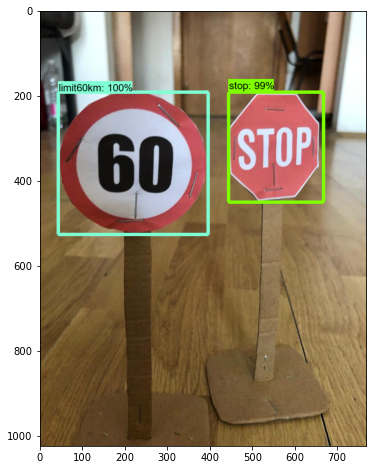

In [44]:
image_path = os.path.join(paths['IMAGE_PATH'], 'test','WhatsApp Image 2022-03-28 at 17.59.50 (12).png')
print('Evaluating:', image_path)
image = Image.open(image_path)
img_width, img_height = image.size
print(type(image))
image_np = np.array(image.getdata()).reshape((img_height, img_width, 3)).astype(np.uint8)
print(type(image_np))
# Run inference.
output_dict = run_inference(detection_graph, image_np)
# Visualization of the results of a detection.
vis_util.visualize_boxes_and_labels_on_image_array(
  image_np,
  output_dict['detection_boxes'],
  output_dict['detection_classes'],
  output_dict['detection_scores'],
  category_index,
  use_normalized_coordinates=True,
  max_boxes_to_draw=5,
  min_score_thresh=.5,  
  line_thickness=8)
plt.figure(figsize=(12, 8))
plt.imshow(image_np)

# Real Time Detections from your Webcam

In [28]:
import cv2

In [30]:
cap = cv2.VideoCapture(0)
width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

while cap.isOpened(): 
    ret, frame = cap.read()
    image_np = frame.reshape((height, width, 3)).astype(np.uint8)
    # Run inference.
    output_dict = run_inference(detection_graph, image_np)
    viz_utils.visualize_boxes_and_labels_on_image_array(
                image_np,
                output_dict['detection_boxes'],
                output_dict['detection_classes'],
                output_dict['detection_scores'],
                category_index,
                use_normalized_coordinates=True,
                max_boxes_to_draw=5,
                min_score_thresh=.6,
                agnostic_mode=False)

    cv2.imshow('object detection',  cv2.resize(image_np, (800, 600)))
    
    if cv2.waitKey(10) & 0xFF == ord('q'):
        cap.release()
        cv2.destroyAllWindows()
        break

# 12. Conversion to TFLite

In [19]:
TFLITE_SCRIPT = os.path.join(paths['APIMODEL_PATH'], 'research', 'object_detection', 'export_tflite_ssd_graph.py')
#CKP=os.path.join(paths['CHECKPOINT_PATH'],'')

          FeatureExtractor/MobileDetEdgeTPU/FusedConv_2/Conv/weights (3x3x16x128, 18.43k/18.43k params)
        FeatureExtractor/MobileDetEdgeTPU/FusedConv_2/Conv_1 (--/2.05k params)
          FeatureExtractor/MobileDetEdgeTPU/FusedConv_2/Conv_1/BatchNorm (--/0 params)
          FeatureExtractor/MobileDetEdgeTPU/FusedConv_2/Conv_1/weights (1x1x128x16, 2.05k/2.05k params)
      FeatureExtractor/MobileDetEdgeTPU/FusedConv_3 (--/10.24k params)
        FeatureExtractor/MobileDetEdgeTPU/FusedConv_3/Conv (--/9.22k params)
          FeatureExtractor/MobileDetEdgeTPU/FusedConv_3/Conv/BatchNorm (--/0 params)
          FeatureExtractor/MobileDetEdgeTPU/FusedConv_3/Conv/weights (3x3x16x64, 9.22k/9.22k params)
        FeatureExtractor/MobileDetEdgeTPU/FusedConv_3/Conv_1 (--/1.02k params)
          FeatureExtractor/MobileDetEdgeTPU/FusedConv_3/Conv_1/BatchNorm (--/0 params)
          FeatureExtractor/MobileDetEdgeTPU/FusedConv_3/Conv_1/weights (1x1x64x16, 1.02k/1.02k params)
      FeatureExtractor/

Profile:
node name | # float_ops
_TFProfRoot (--/3.22m flops)
  FeatureExtractor/MobileDetEdgeTPU/IBN_10/Conv_1/mul_fold (368.64k/368.64k flops)
  FeatureExtractor/MobileDetEdgeTPU/FusedConv_8/Conv/mul_fold (186.62k/186.62k flops)
  FeatureExtractor/MobileDetEdgeTPU/FusedConv_9/Conv/mul_fold (186.62k/186.62k flops)
  FeatureExtractor/MobileDetEdgeTPU/C5_2_Conv2d_2_3x3_s2_512/mul_fold (131.07k/131.07k flops)
  FeatureExtractor/MobileDetEdgeTPU/IBN_9/Conv/mul_fold (115.20k/115.20k flops)
  FeatureExtractor/MobileDetEdgeTPU/IBN_9/Conv_1/mul_fold (115.20k/115.20k flops)
  FeatureExtractor/MobileDetEdgeTPU/IBN_7/Conv_1/mul_fold (115.20k/115.20k flops)
  FeatureExtractor/MobileDetEdgeTPU/IBN_7/Conv/mul_fold (115.20k/115.20k flops)
  FeatureExtractor/MobileDetEdgeTPU/IBN_10/Conv/mul_fold (115.20k/115.20k flops)
  FeatureExtractor/MobileDetEdgeTPU/C5_1_Conv2d_2_1x1_256/mul_fold (98.30k/98.30k flops)
  FeatureExtractor/MobileDetEdgeTPU/IBN_6/Conv_1/mul_fold (92.16k/92.16k flops)
  FeatureExtrac

In [20]:
command = "python {} \
--pipeline_config_path={} \
--trained_checkpoint_prefix={} \
--output_directory={} \
--add_postprocessing_op=true".format(TFLITE_SCRIPT ,files['PIPELINE_CONFIG'], last_model_path, paths['TFLITE_PATH'])

  MultipleGridAnchorGenerator/truediv_9 (1/1 flops)
  Postprocessor/BatchMultiClassNonMaxSuppression/map/while/Less (1/1 flops)
  Postprocessor/BatchMultiClassNonMaxSuppression/map/while/Less_1 (1/1 flops)
  MultipleGridAnchorGenerator/mul_11 (1/1 flops)
  MultipleGridAnchorGenerator/mul_10 (1/1 flops)
  MultipleGridAnchorGenerator/mul_1 (1/1 flops)
  MultipleGridAnchorGenerator/mul (1/1 flops)
  MultipleGridAnchorGenerator/Minimum (1/1 flops)
  MultipleGridAnchorGenerator/mul_3 (1/1 flops)
  MultipleGridAnchorGenerator/mul_57 (1/1 flops)
  Postprocessor/BatchMultiClassNonMaxSuppression/map/while/MultiClassNonMaxSuppression/ChangeCoordinateFrame/sub (1/1 flops)
  Postprocessor/BatchMultiClassNonMaxSuppression/map/while/MultiClassNonMaxSuppression/ChangeCoordinateFrame/sub_1 (1/1 flops)
  MultipleGridAnchorGenerator/mul_58 (1/1 flops)
  Postprocessor/BatchMultiClassNonMaxSuppression/map/while/MultiClassNonMaxSuppression/ChangeCoordinateFrame/truediv (1/1 flops)
  Postprocessor/BatchMult

In [21]:
print(command)

python Tensorflow\models\research\object_detection\export_tflite_ssd_graph.py --pipeline_config_path=Tensorflow\workspace\models\ssdlite_mobiledet_edgetpu_tuned12\pipeline.config --trained_checkpoint_prefix=Tensorflow\workspace\models\ssdlite_mobiledet_edgetpu_tuned12\model.ckpt-90000 --output_directory=Tensorflow\workspace\models\ssdlite_mobiledet_edgetpu_tuned12\tfliteexport --add_postprocessing_op=true


In [22]:
!{command}

2022-04-03 00:27:21.342773: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library cudart64_100.dll
Instructions for updating:
Please use `layer.__call__` method instead.
W0403 00:27:24.317527  8636 deprecation.py:323] From D:\antrenare_cuant\TFODCourse\cuant\lib\site-packages\tf_slim\layers\layers.py:1089: Layer.apply (from tensorflow.python.keras.engine.base_layer) is deprecated and will be removed in a future version.
Instructions for updating:
Please use `layer.__call__` method instead.
INFO:tensorflow:depth of additional conv before box predictor: 0
I0403 00:27:26.352981  8636 convolutional_box_predictor.py:156] depth of additional conv before box predictor: 0
INFO:tensorflow:depth of additional conv before box predictor: 0
I0403 00:27:26.418838  8636 convolutional_box_predictor.py:156] depth of additional conv before box predictor: 0
INFO:tensorflow:depth of additional conv before box predictor: 0
I0403 00:27:26.503611  8636 convolutio

I0403 00:27:29.636052  8636 quantize.py:299] Skipping quant after FeatureExtractor/MobileDetEdgeTPU/IBN_10/SeparableConv2d/add_fold
INFO:tensorflow:Skipping quant after FeatureExtractor/MobileDetEdgeTPU/C5_1_Conv2d_2_1x1_256/add_fold
I0403 00:27:29.636052  8636 quantize.py:299] Skipping quant after FeatureExtractor/MobileDetEdgeTPU/C5_1_Conv2d_2_1x1_256/add_fold
INFO:tensorflow:Skipping quant after FeatureExtractor/MobileDetEdgeTPU/C5_2_Conv2d_2_3x3_s2_512_depthwise/add_fold
I0403 00:27:29.636052  8636 quantize.py:299] Skipping quant after FeatureExtractor/MobileDetEdgeTPU/C5_2_Conv2d_2_3x3_s2_512_depthwise/add_fold
INFO:tensorflow:Skipping quant after FeatureExtractor/MobileDetEdgeTPU/C5_2_Conv2d_2_3x3_s2_512/add_fold
I0403 00:27:29.636052  8636 quantize.py:299] Skipping quant after FeatureExtractor/MobileDetEdgeTPU/C5_2_Conv2d_2_3x3_s2_512/add_fold
INFO:tensorflow:Skipping quant after FeatureExtractor/MobileDetEdgeTPU/C5_1_Conv2d_3_1x1_128/add_fold
I0403 00:27:29.637049  8636 quantiz

In [23]:
FROZEN_TFLITE_PATH = os.path.join(paths['TFLITE_PATH'], 'tflite_graph.pb')
TFLITE_MODEL = os.path.join(paths['TFLITE_PATH'], 'traffic.tflite')

In [24]:
command = "tflite_convert \
--output_file={} \
--graph_def_file={} \
--inference_type=QUANTIZED_UINT8 \
--input_arrays=normalized_input_image_tensor \
--output_arrays=TFLite_Detection_PostProcess,TFLite_Detection_PostProcess:1,TFLite_Detection_PostProcess:2,TFLite_Detection_PostProcess:3 \
--mean_values=128 \
--std_dev_values=128 \
--input_shapes=1,320,320,3 \
--change_concat_input_ranges=false \
--allow_nudging_weights_to_use_fast_gemm_kernel=true \
--allow_custom_ops".format(TFLITE_MODEL, FROZEN_TFLITE_PATH )

In [25]:
print(command)

tflite_convert --output_file=Tensorflow\workspace\models\ssdlite_mobiledet_edgetpu_tuned12\tfliteexport\traffic.tflite --graph_def_file=Tensorflow\workspace\models\ssdlite_mobiledet_edgetpu_tuned12\tfliteexport\tflite_graph.pb --inference_type=QUANTIZED_UINT8 --input_arrays=normalized_input_image_tensor --output_arrays=TFLite_Detection_PostProcess,TFLite_Detection_PostProcess:1,TFLite_Detection_PostProcess:2,TFLite_Detection_PostProcess:3 --mean_values=128 --std_dev_values=128 --input_shapes=1,320,320,3 --change_concat_input_ranges=false --allow_nudging_weights_to_use_fast_gemm_kernel=true --allow_custom_ops


In [26]:
!{command}

2022-04-03 00:27:35.676619: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library cudart64_100.dll
2022-04-03 00:27:37.830708: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library nvcuda.dll
2022-04-03 00:27:38.158716: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1618] Found device 0 with properties: 
name: GeForce GTX 1050 major: 6 minor: 1 memoryClockRate(GHz): 1.493
pciBusID: 0000:01:00.0
2022-04-03 00:27:38.158741: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library cudart64_100.dll
2022-04-03 00:27:38.161750: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library cublas64_100.dll
2022-04-03 00:27:38.165047: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library cufft64_100.dll
2022-04-03 00:27:38.166266: I tensorflow/stream_executor/platform/defaul

# 13. Evaluarea modelului TFLITE

Evaluating: Tensorflow\workspace\images\test\WhatsApp Image 2022-03-26 at 17.03.20 (19).png


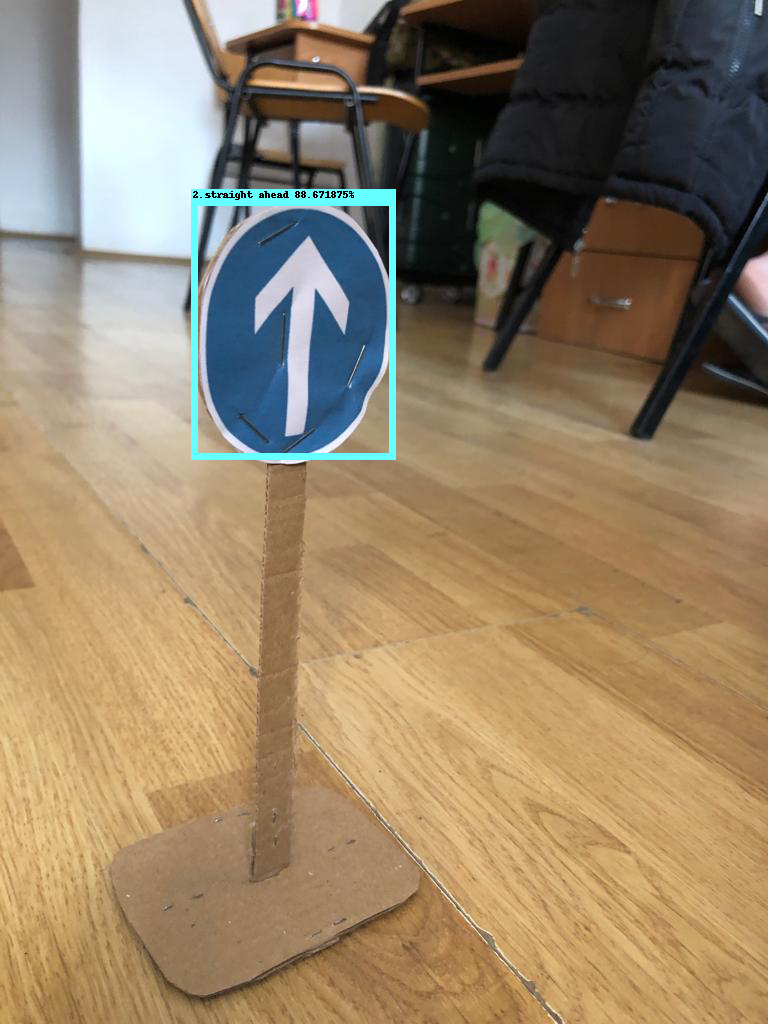

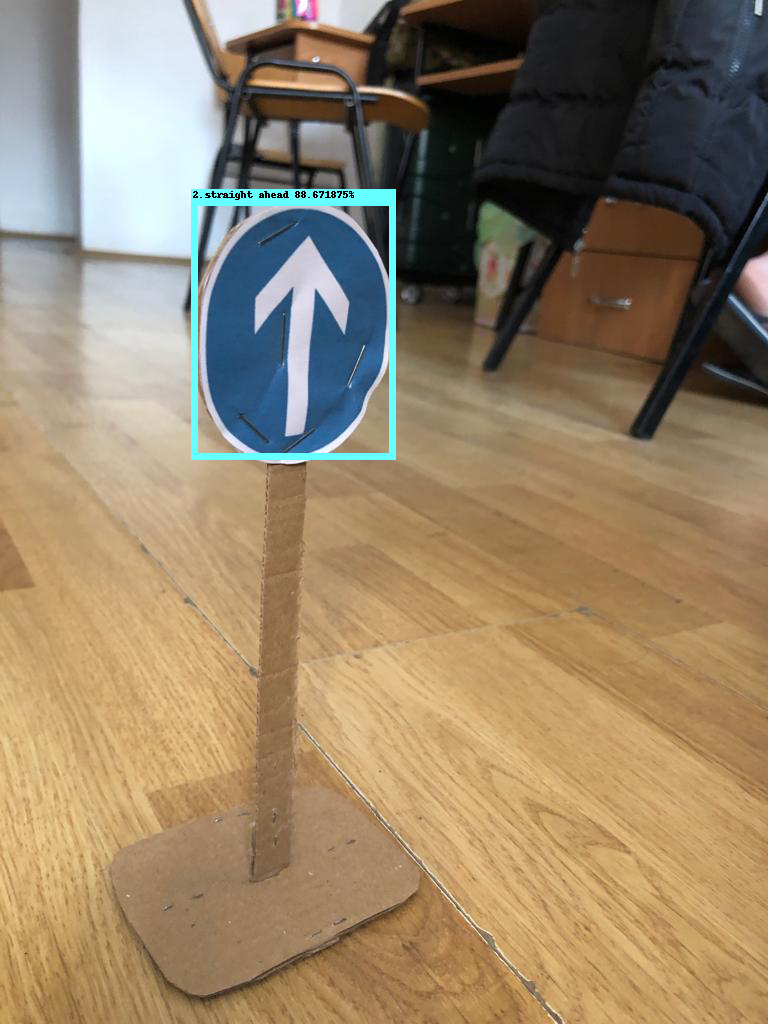

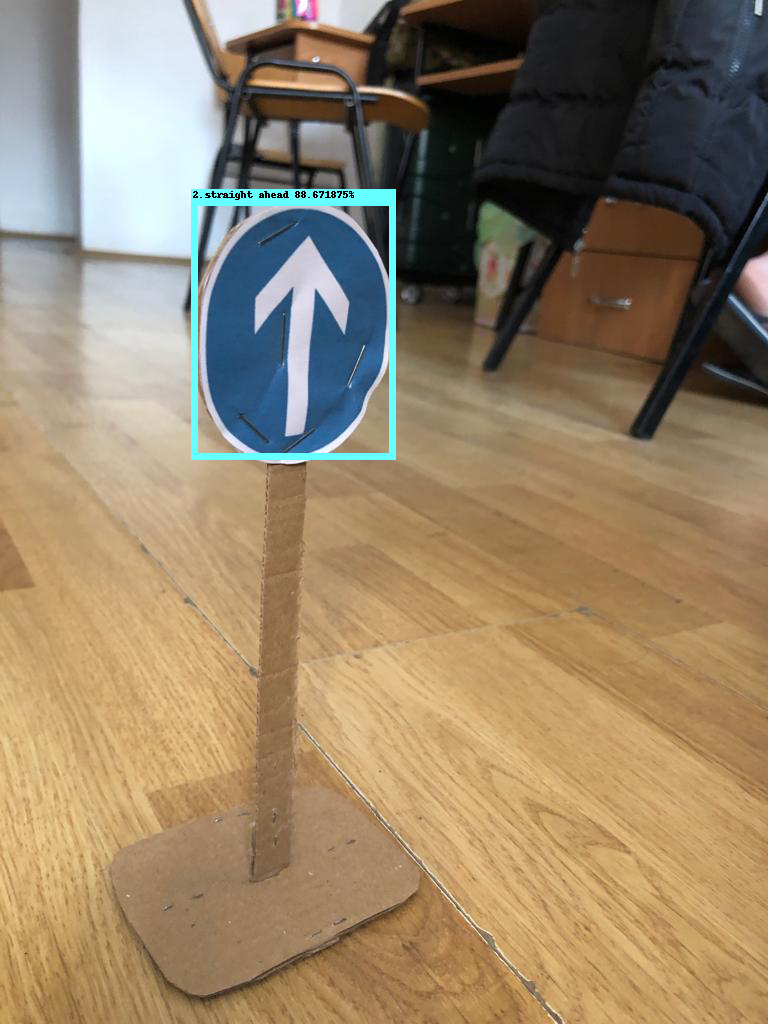

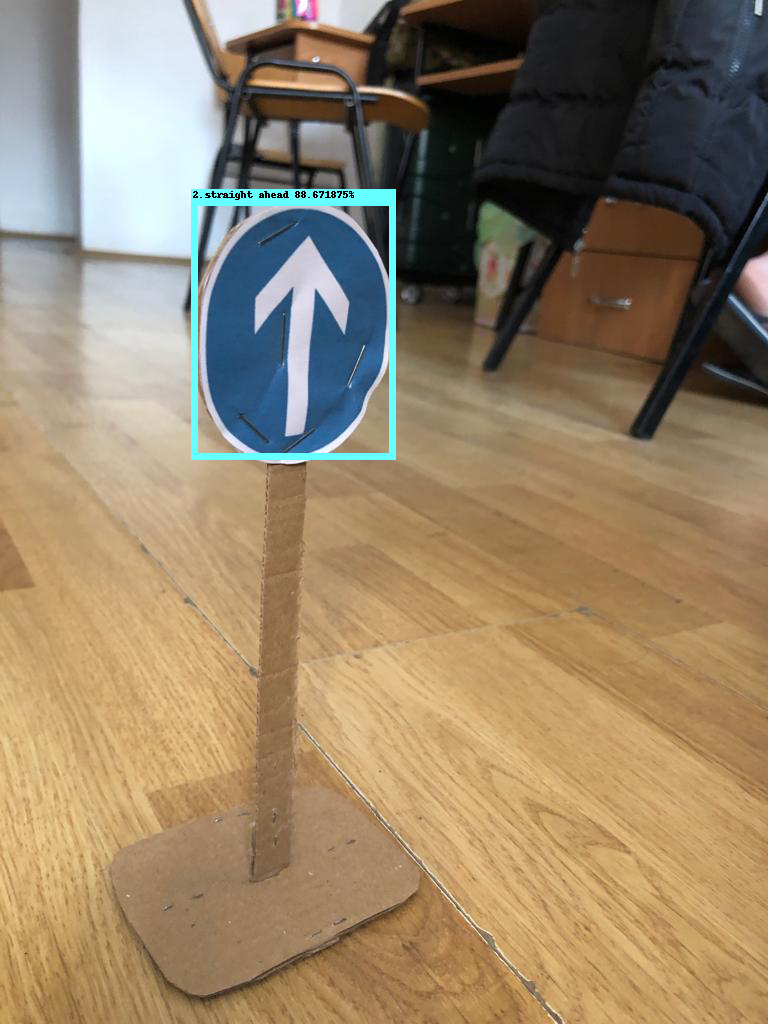

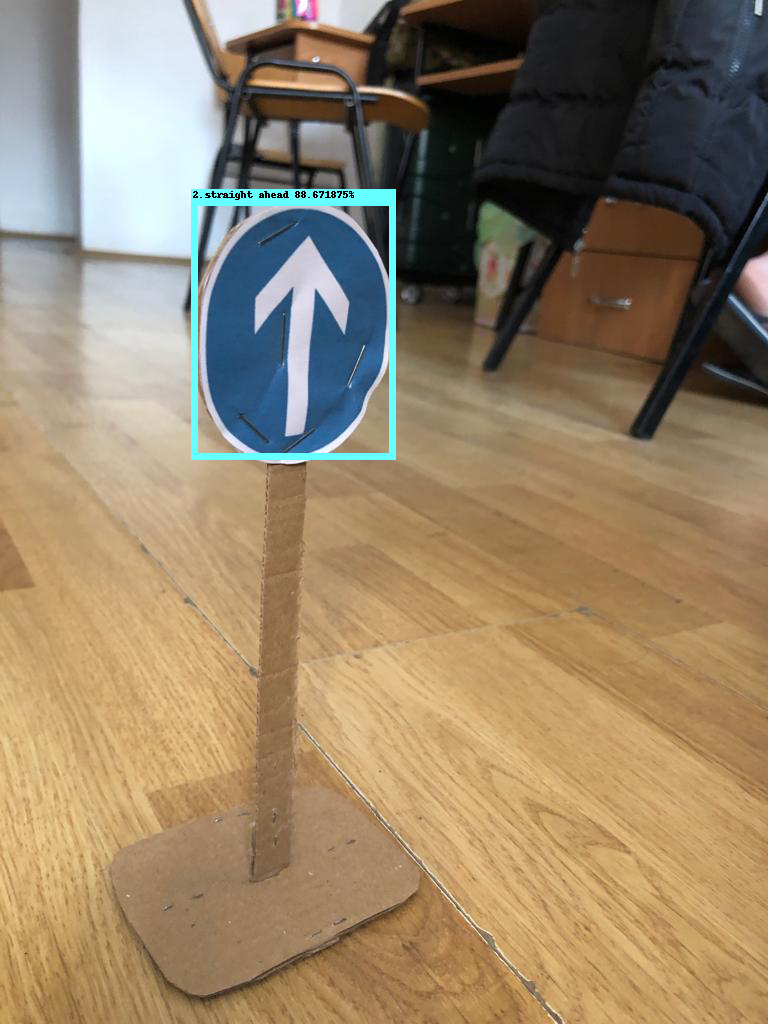

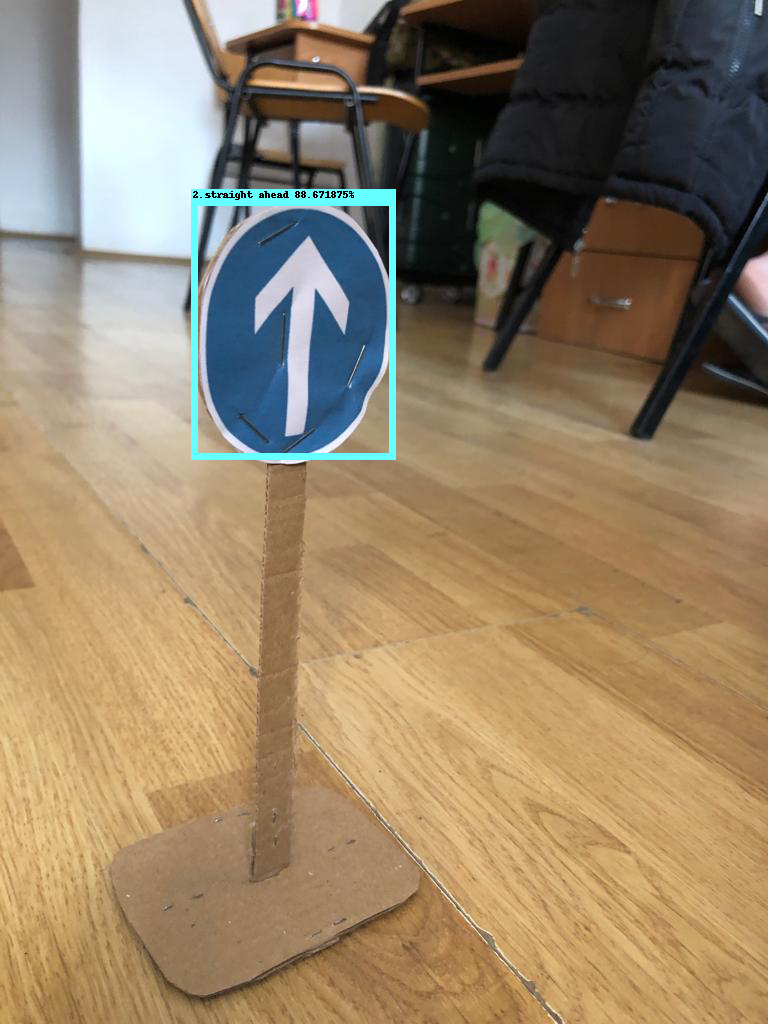

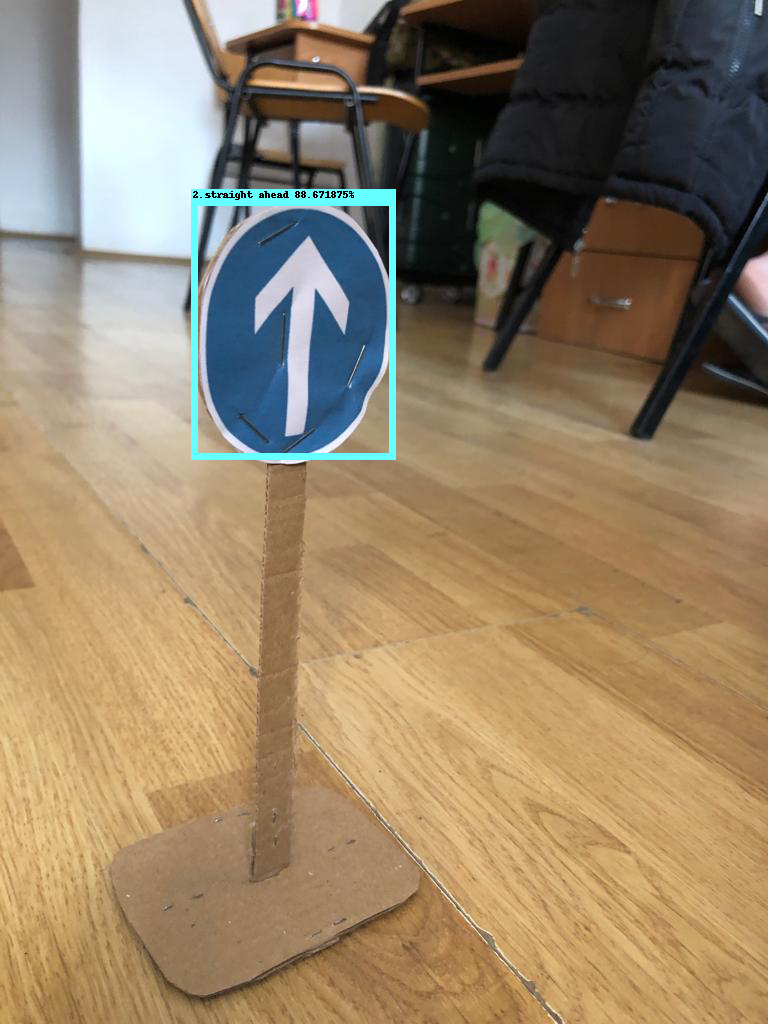

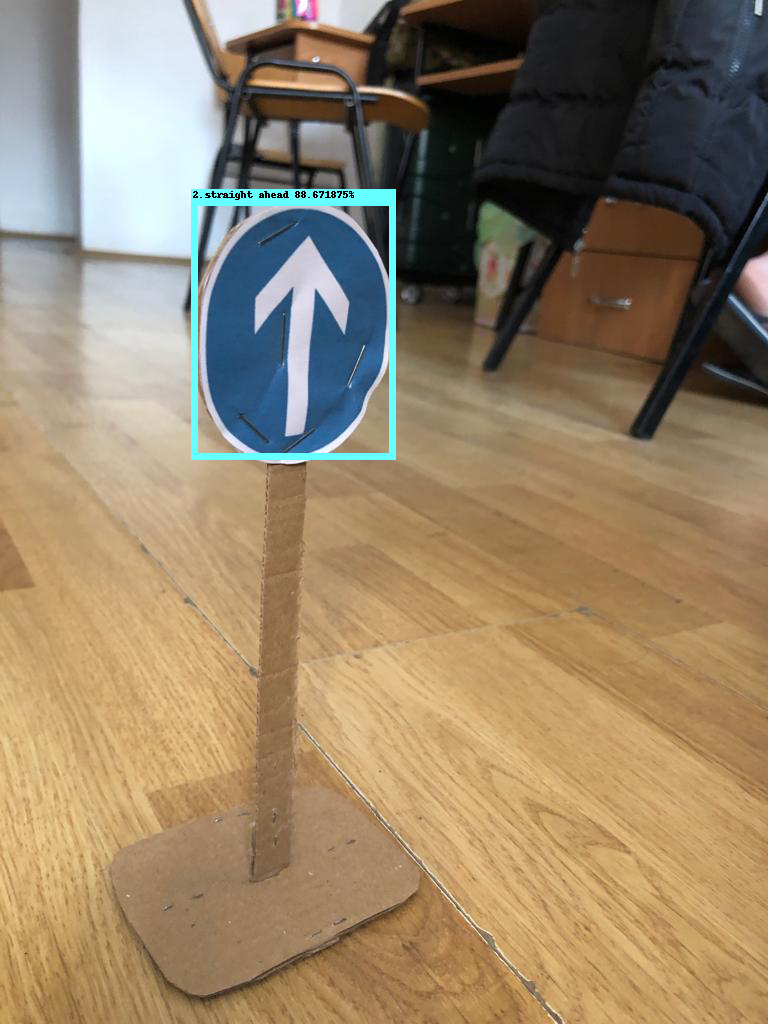

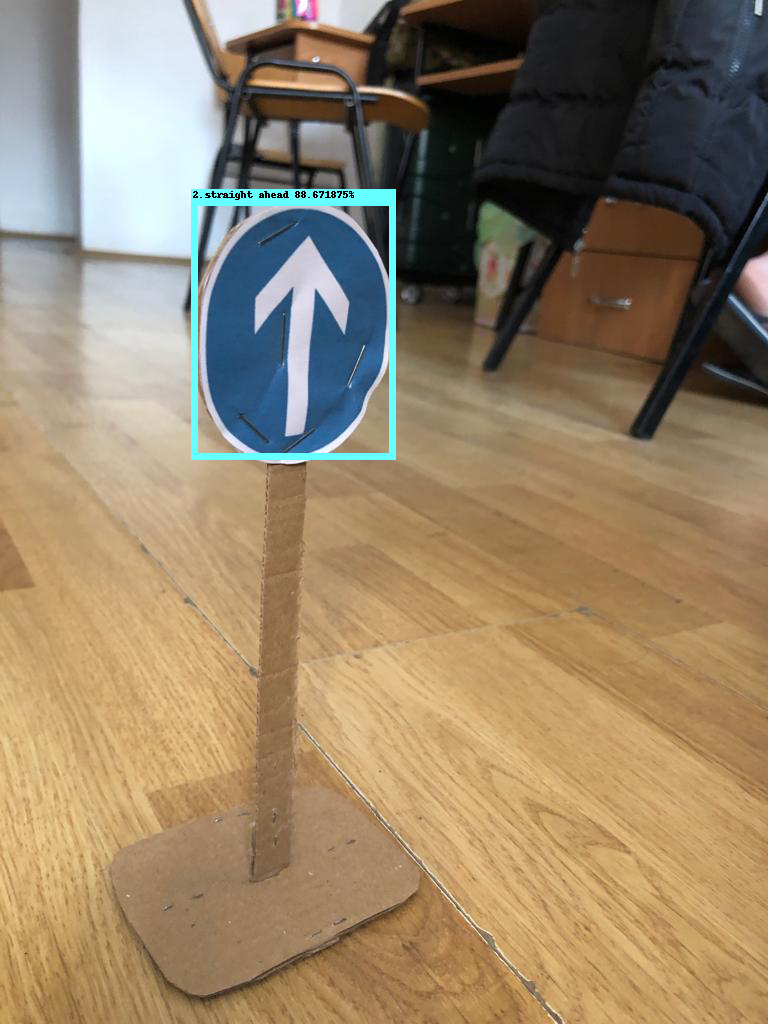

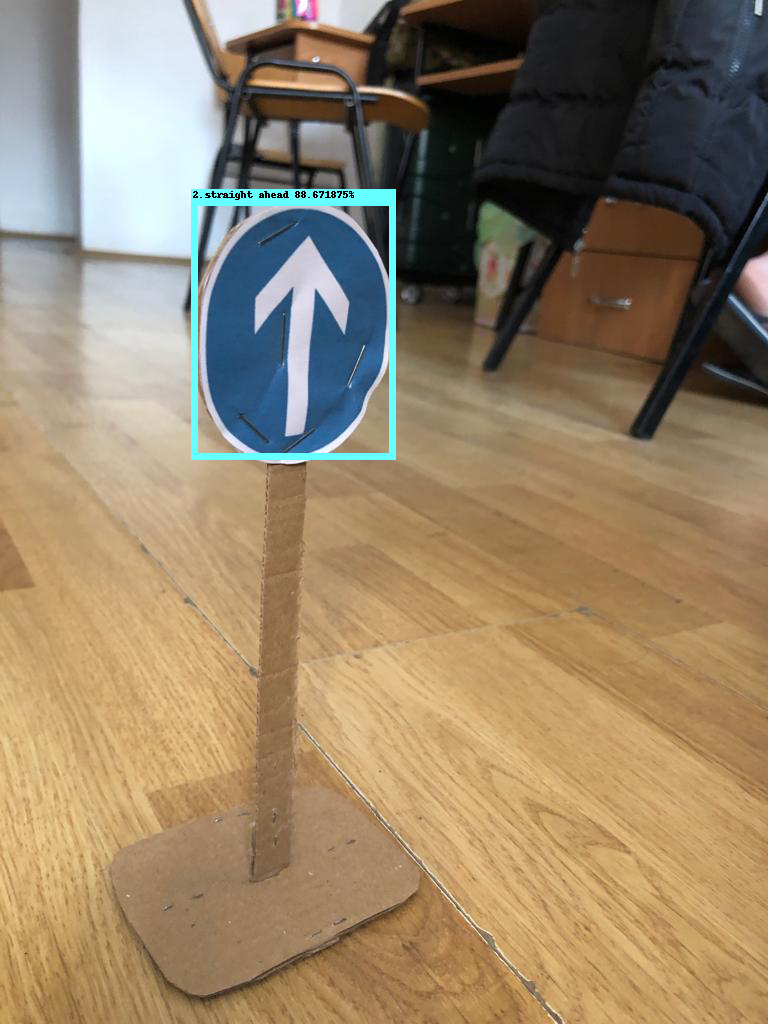

In [56]:
import os
import re
import numpy as np
from PIL import Image
from PIL import ImageDraw
%matplotlib inline

TFLITE=os.path.join(paths['TFLITE_PATH'] , 'traffic.tflite')

# Creates tflite interpreter
interpreter =  tf.lite.Interpreter(model_path=str(TFLITE))
interpreter.allocate_tensors()
interpreter.invoke() # warmup
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()
width = input_details[0]['shape'][2]
height = input_details[0]['shape'][1]

def read_label_file(file_path):
  with open(file_path, 'r', encoding='utf-8') as f:
    lines = f.readlines()
  ret = {}
  for row_number, content in enumerate(lines):
    pair = re.split(r'[:\s]+', content.strip(), maxsplit=1)
    if len(pair) == 2 and pair[0].strip().isdigit():
      ret[int(pair[0])] = pair[1].strip()
    else:
      ret[row_number] = content.strip()
  return ret

def run_inference(interpreter, image):
  interpreter.set_tensor(input_details[0]['index'], image)
  interpreter.invoke()
  boxes = interpreter.get_tensor(output_details[0]['index'])[0]
  classes = interpreter.get_tensor(output_details[1]['index'])[0]
  scores = interpreter.get_tensor(output_details[2]['index'])[0]
  # num_detections = interpreter.get_tensor(output_details[3]['index'])[0]
  return boxes, classes, scores

image_path = os.path.join(paths['IMAGE_PATH'], 'test','WhatsApp Image 2022-03-26 at 17.03.20 (19).png')
print('Evaluating:', image_path)
image = Image.open(image_path)
image_width, image_height = image.size
draw = ImageDraw.Draw(image)
resized_image = image.resize((width, height))
np_image = np.asarray(resized_image)
input_tensor = np.expand_dims(np_image, axis=0)
# Run inference
boxes, classes, scores = run_inference(interpreter, input_tensor)
# Draw results on image
colors = {0:(128, 255, 102), 1:(102, 255, 255)}
ANNOTATIONS=os.path.join(paths['ANNOTATION_PATH'] , 'labels.txt')
labels = read_label_file(ANNOTATIONS)
for i in range(len(boxes)):
    if scores[i] > .6:
      ymin = int(max(1, (boxes[i][0] * image_height)))
      xmin = int(max(1, (boxes[i][1] * image_width)))
      ymax = int(min(image_height, (boxes[i][2] * image_height)))
      xmax = int(min(image_width, (boxes[i][3] * image_width)))
      draw.rectangle((xmin, ymin, xmax, ymax), width=7, outline=colors[int(classes[i])])
      draw.rectangle((xmin, ymin, xmax, ymin-10), fill=colors[int(classes[i])])
      text = labels[int(classes[i])] + ' ' + str(scores[i]*100) + '%'
      draw.text((xmin+2, ymin-10), text, fill=(0,0,0), width=2)
    display(image)

# 14. Compilarea pentru Edge TPU

In [53]:
#instalarea compilatorului
! curl https://packages.cloud.google.com/apt/doc/apt-key.gpg | apt-key add -
! echo "deb https://packages.cloud.google.com/apt coral-edgetpu-stable main" | sudo tee /etc/apt/sources.list.d/coral-edgetpu.list
! sudo apt-get update
! sudo apt-get install edgetpu-compiler

'apt-key' is not recognized as an internal or external command,
operable program or batch file.
'sudo' is not recognized as an internal or external command,
operable program or batch file.
'sudo' is not recognized as an internal or external command,
operable program or batch file.
'sudo' is not recognized as an internal or external command,
operable program or batch file.


In [ ]:
%cd paths['TFLITE_PATH']

! edgetpu_compiler -s traffic.tflite

# 15. Rularea pe Edge TPU

In [ ]:
wget https://c4.staticflickr.com/8/7580/15865399370_ffa5b49d20_z.jpg -O dog.jpg && \
wget https://c6.staticflickr.com/9/8534/8652503705_687d957a29_z.jpg -O cat.jpg

In [ ]:
git clone https://github.com/google-coral/pycoral

cd pycoral/examples/

python3 detect_image.py \
  --model ssdlite_mobiledet_dog_vs_cat_edgetpu.tflite \
  --labels labels.txt \
  --input dog.jpg \
  --output dog_result.jpg